In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean, cosine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
import scipy.linalg as la

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# race_train_df = pd.read_parquet('./data/race_train_prepared.parquet')
# race_test_df = pd.read_parquet('./data/race_test_prepared.parquet')
# dolly_cqa_df = pd.read_parquet('./data/dolly_cqa_prepared.parquet')

In [3]:
# from readability import Readability

# def compute_readability(text):
#     r = Readability(text)
#     gf = r.gunning_fog()
#     gf_score = gf.score
#     return gf_score

# race_train_df['gf_score'] = race_train_df['text'].apply(lambda x: compute_readability(x))
# race_test_df['gf_score'] = race_test_df['text'].apply(lambda x: compute_readability(x))
# dolly_cqa_df['gf_score'] = dolly_cqa_df['text'].apply(lambda x: compute_readability(x))

In [4]:
# race_train_df.to_parquet('./data/race_train_df_readability.parquet', index=False)
# race_test_df.to_parquet('./data/race_test_df_readability.parquet', index=False)
# dolly_cqa_df.to_parquet('./data/dolly_cqa_df_readability.parquet', index=False)

In [5]:
race_train_df = pd.read_parquet('./data/race_train_df_readability.parquet')
race_test_df = pd.read_parquet('./data/race_test_df_readability.parquet')
dolly_cqa_df = pd.read_parquet('./data/dolly_cqa_df_readability.parquet')

<AxesSubplot:>

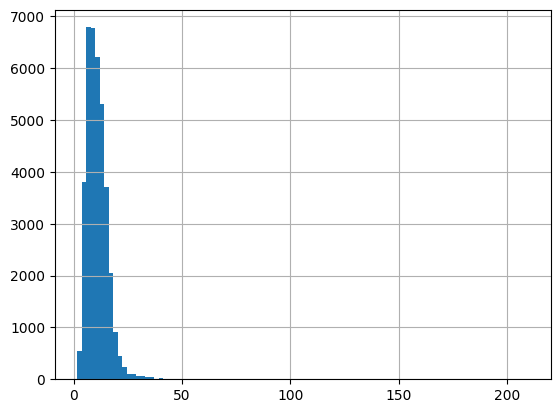

In [6]:
race_train_df['gf_score'].hist(bins=100)

<AxesSubplot:>

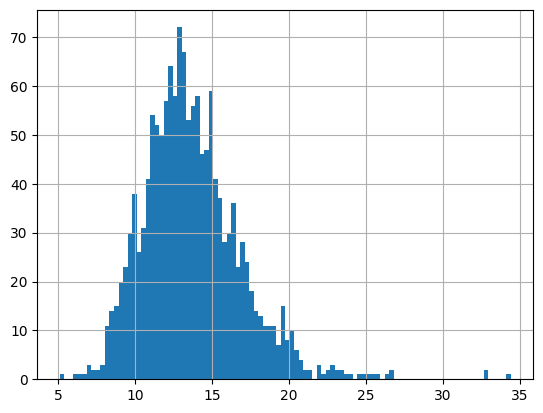

In [7]:
dolly_cqa_df['gf_score'].hist(bins=100)

In [8]:
# race_train_df = race_train_df[race_train_df['gf_score'] >= 5]
race_train_df = race_train_df[race_train_df['gf_score'] <= 35]

# race_test_df = race_test_df[race_test_df['gf_score'] >= 5]
race_test_df = race_test_df[race_test_df['gf_score'] <= 35]

<AxesSubplot:>

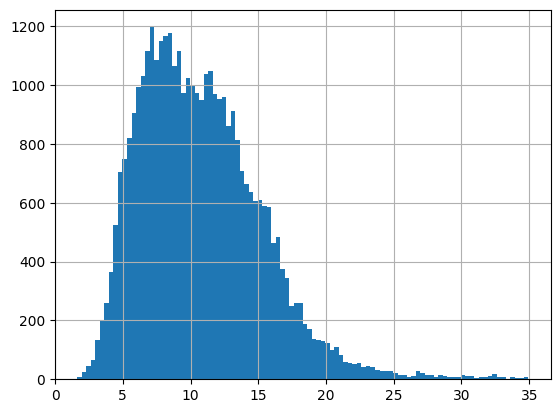

In [9]:
race_train_df['gf_score'].hist(bins=100)

In [10]:
# def equal_frequency_binning(data, num_bins):
#     """
#     Bucketize the data into bins with approximately equal number of data points.
    
#     Parameters:
#     - data (list or np.array): The data to be bucketized.
#     - num_bins (int): Number of bins desired.
    
#     Returns:
#     - bins (list of tuples): List of intervals representing the bins.
#     """
    
#     if not isinstance(data, np.ndarray):
#         data = np.array(data)
    
#     # Sort the data
#     sorted_data = np.sort(data)
    
#     # Calculate bin edges using quantiles
#     bin_edges = [np.percentile(sorted_data, i) for i in np.linspace(0, 100, num_bins+1)]
    
#     # Create bins as tuples of (start, end)
#     bins = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    
#     return bins

# def bin_data(data, bins, bin_names):
#     """
#     Convert continuous data into categorical data using specified bins and bin names.
    
#     Parameters:
#     - data (list or np.array): The data to be bucketized.
#     - bins (list of tuples): List of intervals representing the bins.
#     - bin_names (list of str): Names for each bin.
    
#     Returns:
#     - categorical_data (list of str): Categorical representation of the data.
#     """
    
#     if not isinstance(data, np.ndarray):
#         data = np.array(data)
    
#     if len(bins) != len(bin_names):
#         raise ValueError("Number of bins and bin names should be the same.")
    
#     # Initialize an empty list to store the categorical data
#     categorical_data = []
    
#     # Loop over each data point to assign it to a bin
#     for value in data:
#         assigned = False
#         for i, (start, end) in enumerate(bins):
#             if start <= value < end or (i == len(bins) - 1 and value == end):
#                 categorical_data.append(bin_names[i])
#                 assigned = True
#                 break
#         if not assigned:
#             categorical_data.append('Unknown')
    
#     return categorical_data

def bucketize_by_quantiles(df, column_name, n_buckets):
    """
    Bucketizes the continuous values in the specified column of the DataFrame into
    n_buckets using quantiles, and returns a new categorical column with the bucketized values.
    
    Parameters:
    - df: pandas DataFrame
    - column_name: Name of the column with continuous values
    - n_buckets: Number of buckets to create
    
    Returns:
    - A new column with bucketized values
    """
    bucket_labels = [f"L{i+1}" for i in range(n_buckets)]
    return pd.qcut(df[column_name], q=n_buckets, labels=bucket_labels)

# def bucketize(df, column_name):
#     # Create an ordered index based on the values in the column
#     ordered_index = df[column_name].sort_values().index
    
#     # Round the continuous values to nearest integer
#     df['rounded'] = df[column_name].round().astype(int)
    
#     # Apply rolling window on ordered values to compute the middle value for each window
#     bucketized = df.loc[ordered_index, 'rounded'].rolling(window=3, center=True).apply(lambda x: x[1], raw=True)
    
#     # Fill NaN values for beginning edge with the first valid bucket value
#     first_valid_bucket = bucketized.dropna().iloc[0]
#     bucketized.iloc[:bucketized.first_valid_index()] = first_valid_bucket
    
#     # Fill NaN values for ending edge with the last valid bucket value
#     last_valid_bucket = bucketized.dropna().iloc[-1]
#     bucketized.iloc[bucketized.last_valid_index()+1:] = last_valid_bucket
    
#     # Convert the bucketized values to integers
#     bucketized = bucketized.astype(int)
    
#     # Convert the integer values to strings by prepending "L" to them
#     bucketized = 'L' + bucketized.astype(str)
    
#     # Restore the original order
#     bucketized = bucketized.reindex(df.index)
    
#     # Drop the temporary 'rounded' column
#     df.drop('rounded', axis=1, inplace=True)
    
#     return bucketized

In [11]:
# bins_race_train = equal_frequency_binning(race_train_df['gf_score'], num_bins=15)
# race_train_df['gf_score_categ'] = bin_data(race_train_df['gf_score'], bins_race_train, ['L' + str(i) for i in range(1,16)])

# bins_race_test = equal_frequency_binning(race_test_df['gf_score'], num_bins=15)
# race_test_df['gf_score_categ'] = bin_data(race_test_df['gf_score'], bins_race_test, ['L' + str(i) for i in range(1,16)])

# bins_dolly = equal_frequency_binning(dolly_cqa_df['gf_score'], num_bins=15)
# dolly_cqa_df['gf_score_categ'] = bin_data(dolly_cqa_df['gf_score'], bins_dolly, ['L' + str(i) for i in range(1,16)])

# race_train_df['gf_score_categ'] = race_train_df['gf_score'].apply(lambda x: str(round(x)))
# race_test_df['gf_score_categ'] = race_test_df['gf_score'].apply(lambda x: str(round(x)))
# dolly_cqa_df['gf_score_categ'] = dolly_cqa_df['gf_score'].apply(lambda x: str(round(x)))

race_train_df['gf_score_categ'] = bucketize_by_quantiles(df=race_train_df, column_name='gf_score', n_buckets=10)
race_test_df['gf_score_categ'] = bucketize_by_quantiles(df=race_test_df, column_name='gf_score', n_buckets=10)
dolly_cqa_df['gf_score_categ'] = bucketize_by_quantiles(df=dolly_cqa_df, column_name='gf_score', n_buckets=10)

In [12]:
labels = race_train_df['gf_score_categ'].unique()
labels = sorted(labels, key=lambda x: int(x[1:]))
labels

['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10']

In [13]:
labels = race_test_df['gf_score_categ'].unique()
labels = sorted(labels, key=lambda x: int(x[1:]))
labels

['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10']

In [14]:
labels = dolly_cqa_df['gf_score_categ'].unique()
labels = sorted(labels, key=lambda x: int(x[1:]))
labels

['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10']

In [15]:
def train_lr_classifier(df, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())
    
    y = df[y_col]
    
    # Label encoding the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Initialize LR classifier
    # clf = LogisticRegressionCV(cv=5, scoring='f1_macro', max_iter=1000, n_jobs=-1)
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=20000)

    # Fit the classifier
    clf.fit(X, y_encoded)

    return le, clf

def get_predictions(df, le, clf, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())
    
    y = df[y_col]

    # Label encoding the target variable
    y_encoded = le.transform(y)

    # Predictions
    y_pred_encoded = clf.predict(X)
    y_pred_proba = clf.predict_proba(X)

    # Reverse-transform the predicted and actual labels to their original values
    y_pred = le.inverse_transform(y_pred_encoded)
    y_test = le.inverse_transform(y_encoded)

    # Printing the classification report
    print(classification_report(y_test, y_pred))

    # Plotting the confusion matrix
    labels = df[y_col].unique().tolist()
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return y_pred, y_pred_proba

def create_clusters(df, n_clusters):
    clusters = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit( [v for v in df['embeddings_bge_large']])
    return clusters.labels_

In [16]:
le, clf = train_lr_classifier(df=race_train_df, embeddings_col='embeddings_bge_large', y_col='difficulty')

              precision    recall  f1-score   support

           C       0.82      0.71      0.76       708
           H       0.64      0.72      0.68       707
           M       0.81      0.82      0.82       676

    accuracy                           0.75      2091
   macro avg       0.76      0.75      0.75      2091
weighted avg       0.76      0.75      0.75      2091



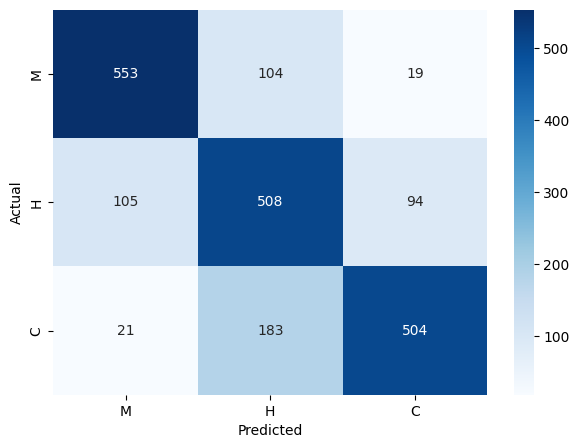

,example_id,article,answer,question,options,difficulty,text,embeddings_mini_lm,embeddings_bge_large,fk_score,fk_score_categ,gf_score,gf_score_categ,predicted_difficulty,difficulty_proba_C,difficulty_proba_H,difficulty_proba_M,cluster
0,middle6673.txt,Mother loves her son. But he is a bad boy. He ...,2,What does the boy do every day?,['He goes to school.' 'He cooks every day.'\n ...,M,### CONTEXT ###\nMother loves her son. But he ...,"[-0.08285892754793167, 0.08668268471956253, 0....","[0.7998983263969421, -0.16793034970760345, 0.2...",1.428839,easy,4.470470,L1,M,0.014758,0.011350,9.738918e-01,2
1,middle5072.txt,Do you help with chores at home? These are wha...,1,What can we learn from the passage?,['Manuel is good at cooking.' 'Maybe Arthur ha...,M,### CONTEXT ###\nDo you help with chores at ho...,"[-0.09754877537488937, 0.041119806468486786, 0...","[-0.12698052823543549, 0.05871523171663284, -0...",4.094385,easy,6.292956,L2,M,0.021642,0.449314,5.290441e-01,7
2,middle6965.txt,"As kids, we learn how to write, maybe play a m...",1,"In the writer's first coding class, she _ .",['made apps and games' 'created a web page' 'w...,M,"### CONTEXT ###\nAs kids, we learn how to writ...","[-0.02396281808614731, 0.041761502623558044, 0...","[0.6323241591453552, -0.1685527265071869, -0.2...",7.015463,medium,8.807407,L4,M,0.000633,0.081194,9.181726e-01,7
3,middle7159.txt,If you could see a movie of your life before y...,2,What troubles Allison after graduation?,"[""She couldn't find a well-paid job.""\n 'She h...",M,### CONTEXT ###\nIf you could see a movie of y...,"[-0.0020361344795674086, 0.042117245495319366,...","[0.44568178057670593, 0.2012404501438141, 0.11...",5.936928,easy,8.182445,L4,M,0.000700,0.230415,7.688851e-01,7
4,middle432.txt,Did you notice the number on the book in a lib...,1,"According to the reading, which sentence is TRUE?","[""The number on a book can't be bigger than 90...",M,### CONTEXT ###\nDid you notice the number on ...,"[-0.0014026855351403356, 0.028585389256477356,...","[1.5601633787155151, 0.3308599591255188, 0.183...",5.239505,easy,8.216065,L4,M,0.004357,0.026470,9.691738e-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,2664.txt,Not everyone in the world requires the same am...,1,Which of the following is TRUE according to th...,['Americans are trained to live in large rooms...,C,### CONTEXT ###\nNot everyone in the world req...,"[0.053262945264577866, -0.10596633702516556, 0...","[1.0040448904037476, -0.6670923233032227, 0.01...",8.981492,medium,11.429612,L7,C,0.999000,0.001000,1.533827e-07,6
2087,3785.txt,In 1977 ecologists Stephen Hubbell and Leslie ...,0,"According to paragraph 4, why did Hubbell and ...",['To determine whether the availability of pot...,C,### CONTEXT ###\nIn 1977 ecologists Stephen Hu...,"[-0.017380768433213234, 0.048852842301130295, ...","[0.6190937757492065, -0.255521297454834, 0.336...",12.504105,hard,16.004086,L9,C,0.994190,0.005810,1.203396e-07,6
2088,2012.txt,The spectacular aurora light displays that app...,0,Which of the following terms is defined in the...,"['""magnetosphere"" (line 6)' '""electrons"" (line...",C,### CONTEXT ###\nThe spectacular aurora light ...,"[-0.054313406348228455, 0.03299275040626526, 0...","[0.5124013423919678, -0.7839702367782593, 0.02...",11.571709,hard,14.786076,L9,C,0.959540,0.040417,4.271464e-05,6
2089,1641.txt,"Flying over a desert area in an airplane, two ...",2,"The study of trees,branches and roots indicate...",['there were larger amounts of gold in the bra...,C,### CONTEXT ###\nFlying over a desert area in ...,"[0.09339334070682526, 0.03183355554938316, 0.0...","[0.3303855061531067, 0.4875277578830719, 0.108...",7.440244,medium,9.461867,L5,H,0.227153,0.767714,5.132802e-03,4


In [17]:
y_pred, y_pred_proba = get_predictions(df=race_test_df, le=le, clf=clf, embeddings_col='embeddings_bge_large', y_col='difficulty')

race_test_df['predicted_difficulty'] = y_pred
race_test_df['difficulty_proba_C'] = y_pred_proba[:,0]
race_test_df['difficulty_proba_H'] = y_pred_proba[:,1]
race_test_df['difficulty_proba_M'] = y_pred_proba[:,2]

race_test_df['cluster'] = create_clusters(df=race_test_df, n_clusters=10)

race_test_df

In [18]:
X = np.array(dolly_cqa_df['embeddings_bge_large'].tolist())
y_pred_encoded = clf.predict(X)
y_pred_proba = clf.predict_proba(X)
y_pred = le.inverse_transform(y_pred_encoded)

dolly_cqa_df['predicted_difficulty'] = y_pred
dolly_cqa_df['difficulty_proba_C'] = y_pred_proba[:,0]
dolly_cqa_df['difficulty_proba_H'] = y_pred_proba[:,1]
dolly_cqa_df['difficulty_proba_M'] = y_pred_proba[:,2]

dolly_cqa_df['cluster'] = create_clusters(df=dolly_cqa_df, n_clusters=10)

dolly_cqa_df

,instruction,context,response,category,text,embeddings_mini_lm,embeddings_bge_large,fk_score,fk_score_categ,gf_score,gf_score_categ,predicted_difficulty,difficulty_proba_C,difficulty_proba_H,difficulty_proba_M,cluster
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,"### CONTEXT ###\nVirgin Australia, the trading...","[0.07990753650665283, -0.04975801706314087, 0....","[0.5005730390548706, -0.46779343485832214, -1....",9.131896,easy,8.581037,L1,C,0.812709,0.135555,0.051736,3
1,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,### CONTEXT ###\nKomorida was born in Kumamoto...,"[-0.011252421885728836, -0.04460098594427109, ...","[0.64762282371521, 0.43752172589302063, -0.047...",7.643152,easy,8.753746,L1,H,0.337160,0.578892,0.083949,5
2,"Given a reference text about Lollapalooza, whe...",Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...,Lollapalooze is an annual musical festival hel...,closed_qa,### CONTEXT ###\nLollapalooza /ˌlɒləpəˈluːzə/ ...,"[0.06580415368080139, -0.0366082526743412, 0.0...","[0.5144393444061279, 0.18275967240333557, -0.4...",11.617224,medium,12.882230,L5,C,0.567777,0.415551,0.016671,0
3,Who was Kyle Van Zyl playing against when he s...,Van Zyl joined the Eastern Province Kings Acad...,Kyle Van Zyl was playing against Boland U21 wh...,closed_qa,### CONTEXT ###\nVan Zyl joined the Eastern Pr...,"[0.019957538694143295, 0.04702803120017052, -0...","[1.1888214349746704, 0.058644916862249374, -0....",11.474969,medium,13.115723,L5,H,0.010027,0.984449,0.005524,5
4,Who was the first to record the Needles and Pi...,"""Needles and Pins"" is a rock song credited to ...",The first artist to record Needles and Pins so...,closed_qa,"### CONTEXT ###\n""Needles and Pins"" is a rock ...","[-0.08916875720024109, 0.0042908587493002415, ...","[-0.08973768353462219, -0.17643515765666962, 0...",9.573611,easy,10.468959,L2,C,0.875403,0.110330,0.014267,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,How many world championships has Max Verstappe...,"After winning the 2021 Abu Dhabi Grand Prix, V...",Max Verstappen has won 2 Formula One World Cha...,closed_qa,### CONTEXT ###\nAfter winning the 2021 Abu Dh...,"[0.044786978513002396, 0.0190593209117651, -0....","[0.5898312330245972, 0.14761556684970856, -0.4...",7.991569,easy,8.760784,L1,M,0.019292,0.157613,0.823095,3
1457,What is the history of coffee?,The history of coffee dates back to centuries ...,Much of the early history of coffee was tied t...,closed_qa,### CONTEXT ###\nThe history of coffee dates b...,"[0.019176138564944267, 0.02772548422217369, -0...","[0.10451232641935349, 0.22819367051124573, -0....",11.447779,medium,12.734596,L5,H,0.104597,0.892063,0.003340,7
1458,What are common florals found in Zigalga Natio...,Zigalga National Park (Russian: Национальный п...,Zigalga National Park has the majority of its ...,closed_qa,### CONTEXT ###\nZigalga National Park (Russia...,"[-0.026473581790924072, 0.09908297657966614, -...","[0.1897222250699997, 0.41683098673820496, 0.02...",12.950833,medium,12.691808,L5,H,0.047924,0.951170,0.000906,8
1459,What is linux Bootloader,"A bootloader, also spelled as boot loader or c...",A bootloader is a program written in machine c...,closed_qa,"### CONTEXT ###\nA bootloader, also spelled as...","[-0.05690043047070503, 0.05346180498600006, -0...","[0.32251039147377014, -0.2482924461364746, 0.0...",19.799659,hard,22.819580,L10,C,0.979824,0.020175,0.000001,1


In [19]:
def plot_boxplots(df, title):
    plt.figure(figsize=(10, 6))
    
    # sns.boxplot(x='gf_score_categ', y='gf_score', data=df, order=['L' + str(i) for i in range(1,16)])
    
    # labels = df['gf_score_categ'].unique().tolist()
    # labels.sort(key=int)
    # sns.boxplot(x='gf_score_categ', y='gf_score', data=df, order=labels)

    labels = df['gf_score_categ'].unique()
    labels = sorted(labels, key=lambda x: int(x[1:]))
    sns.boxplot(x='gf_score_categ', y='gf_score', data=df, order=labels)
    
    plt.title(title)
    plt.show()

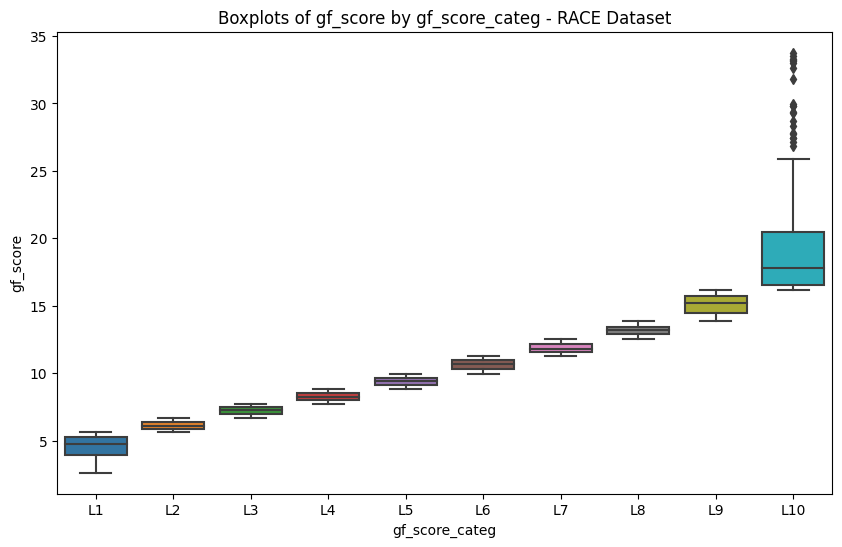

In [20]:
plot_boxplots(df=race_test_df, title='Boxplots of gf_score by gf_score_categ - RACE Dataset')

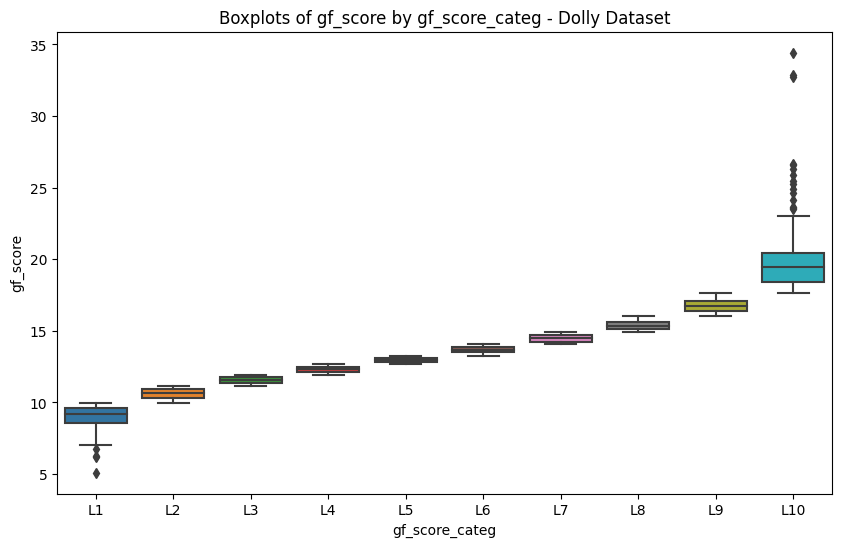

In [21]:
plot_boxplots(df=dolly_cqa_df, title='Boxplots of gf_score by gf_score_categ - Dolly Dataset')

In [22]:
# def plot_mosaic(df, title):
#     # Set the aesthetic style of the plots
#     sns.set_style("whitegrid")

#     # Plotting Mosaic Plot
#     plt.figure(figsize=(12, 6))
#     mosaic(df.sort_values('predicted_difficulty'), ['predicted_difficulty', 'gf_score_categ'], title=title)
#     plt.show()

def plot_stacked(df, title):
    # Plotting Stacked Bar Plot
    contingency_table = pd.crosstab(df['predicted_difficulty'], df['gf_score_categ'])
    contingency_table = contingency_table.reindex(['M', 'H', 'C'])
    
    # contingency_table = contingency_table.reindex(columns=['L' + str(i) for i in range(1,16)])
    
    # labels = df['gf_score_categ'].unique().tolist()
    # labels.sort(key=int)
    # contingency_table = contingency_table.reindex(columns=labels)

    labels = df['gf_score_categ'].unique()
    labels = sorted(labels, key=lambda x: int(x[1:]))
    contingency_table = contingency_table.reindex(columns=labels)

    # Normalizing the contingency table to show percentages
    contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    contingency_table_percentage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.show()
    return contingency_table


In [23]:
# plot_mosaic(df=race_test_df, title='Mosaic Plot of difficulty vs gf_score - RACE Dataset')

In [24]:
# plot_mosaic(df=dolly_cqa_df, title='Mosaic Plot of difficulty vs gf_score - Dolly Dataset')

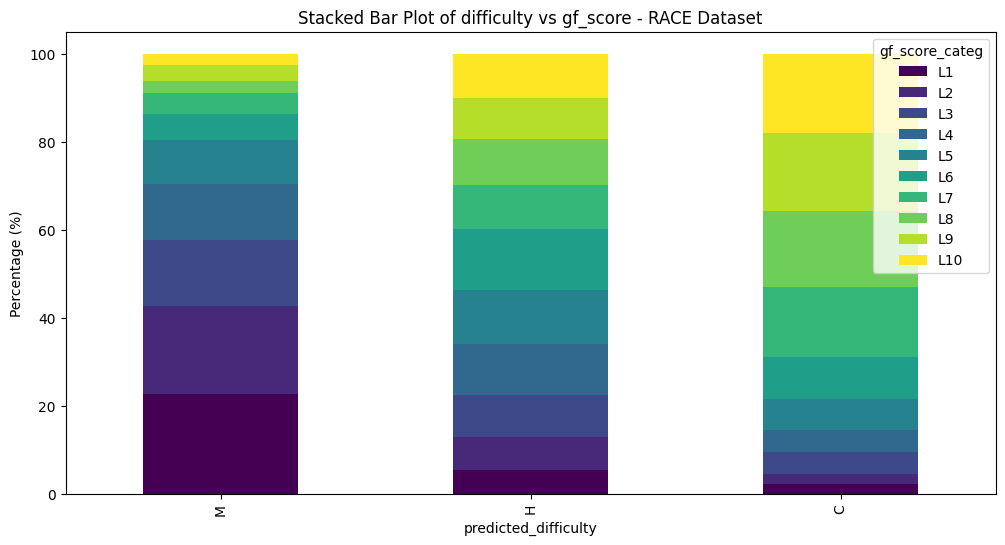

In [25]:
contingency_table_race = plot_stacked(df=race_test_df, title='Stacked Bar Plot of difficulty vs gf_score - RACE Dataset')

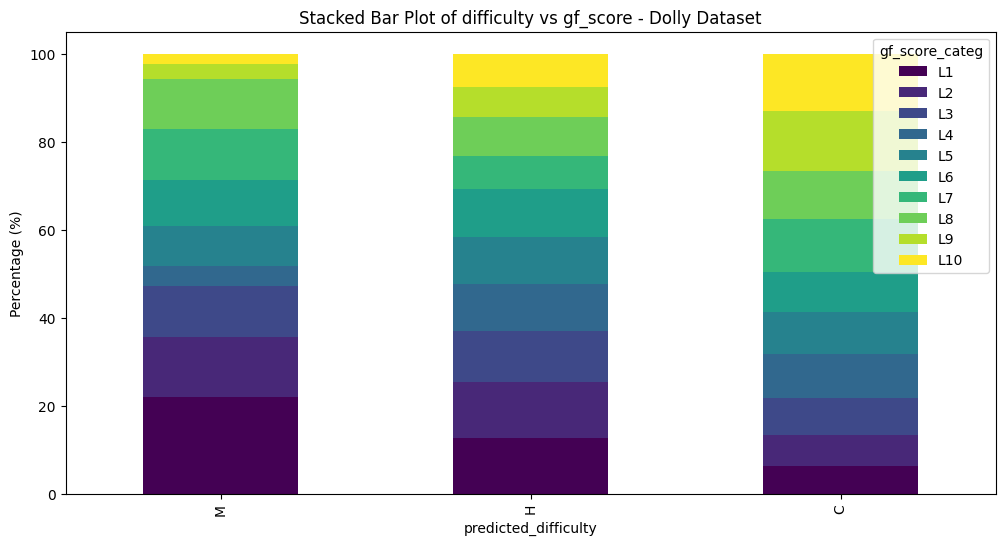

In [26]:
contingency_table_dolly = plot_stacked(df=dolly_cqa_df, title='Stacked Bar Plot of difficulty vs gf_score - Dolly Dataset')

In [27]:
def compute_correlation(contingency_table):
    # Chi-Squared Test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Cramér's V calculation
    chi2_val = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    cramers_v = (chi2_val / (n * min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)))**0.5

    return chi2, p, cramers_v

In [28]:
chi2, p, cramers_v = compute_correlation(contingency_table_race)
print('Chi-squared: ', chi2, ' | p-value: ', p)
print("Cramer's V: ", cramers_v)

Chi-squared:  609.8204889817503  | p-value:  7.2198245125141e-118
Cramer's V:  0.38186424113363104


In [29]:
chi2, p, cramers_v = compute_correlation(contingency_table_dolly)
print('Chi-squared: ', chi2, ' | p-value: ', p)
print("Cramer's V: ", cramers_v)

Chi-squared:  91.75451245682088  | p-value:  6.981734863304466e-12
Cramer's V:  0.17720403640748042


In [81]:
def correspondence_analysis(contingency_table):
    # Calculate row and column marginal totals
    row_totals = contingency_table.sum(axis=1)
    col_totals = contingency_table.sum(axis=0)
    
    # Grand total
    grand_total = contingency_table.sum().sum()
    
    # Expected frequencies under independence
    expected = np.outer(row_totals, col_totals) / grand_total
    
    # Standardized residuals
    S = (contingency_table - expected) / np.sqrt(expected)
    
    # Singular value decomposition
    U, D, Vt = la.svd(S, full_matrices=False)
    
    # Row and column coordinates
    row_coords = U * D
    col_coords = Vt.T * D

    # Percentage of variance explained by each dimension
    explained_variance = (D**2) / sum(D**2)
    
    return row_coords, col_coords, explained_variance


def plot_correspondance_analysis(contingency_table, title, row_label, column_label):
    # Perform correspondence analysis
    row_coords, col_coords, explained_variance = correspondence_analysis(contingency_table)

    # Define row colors
    row_colors = ['red', 'green', 'blue']

    # Plotting the bi-plot
    plt.figure(figsize=(8, 4))
    plt.scatter(row_coords[:, 0], row_coords[:, 1], color='red', marker='o', label=row_label, alpha=0.6)
    plt.scatter(col_coords[:, 0], col_coords[:, 1], color='blue', marker='s', label=column_label, alpha=0.6)

    # Annotate row and column labels
    for idx, label in enumerate(contingency_table.index):
        plt.annotate(label, (row_coords[idx, 0] + 0.05, row_coords[idx, 1] + 0.05), color='red')
    for idx, label in enumerate(contingency_table.columns):
        plt.annotate(label, (col_coords[idx, 0] + 0.05, col_coords[idx, 1] + 0.05), color='blue')

    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(title)
   
    plt.xlabel('Dimension 1: {:.2f}% Explained Variance'.format(explained_variance[0]*100))
    plt.ylabel('Dimension 2: {:.2f}% Explained VAriance'.format(explained_variance[1]*100))
    plt.legend()
    plt.grid(True)
    plt.show()

# def plot_correspondance_analysis(contingency_table, title):
#     # Perform correspondence analysis
#     row_coords, col_coords, explained_variance = correspondence_analysis(contingency_table)

#     # Define row colors
#     row_colors = ['red', 'green', 'blue']

#     # Plotting the bi-plot
#     plt.figure(figsize=(12, 8))

#     # Plot and annotate rows
#     for idx, label in enumerate(contingency_table.index):
#         plt.scatter(row_coords[idx, 0], row_coords[idx, 1], color=row_colors[idx], marker='o', alpha=0.6)
#         plt.annotate(label, (row_coords[idx, 0] + 0.05, row_coords[idx, 1] + 0.05), color=row_colors[idx])
    
#     # Plot and annotate columns based on the closest row point
#     for idx_col, label_col in enumerate(contingency_table.columns):
#         distances = np.linalg.norm(row_coords - col_coords[idx_col], axis=1)
#         closest_row_idx = np.argmin(distances)
#         plt.scatter(col_coords[idx_col, 0], col_coords[idx_col, 1], color=row_colors[closest_row_idx], marker='s', alpha=0.6)
#         plt.annotate(label_col, (col_coords[idx_col, 0] + 0.05, col_coords[idx_col, 1] + 0.05), color=row_colors[closest_row_idx])

#     plt.axhline(0, color='gray', linestyle='--')
#     plt.axvline(0, color='gray', linestyle='--')
#     plt.title(title)
   
#     plt.xlabel('Dimension 1: {:.2f}%'.format(explained_variance[0]*100))
#     plt.ylabel('Dimension 2: {:.2f}%'.format(explained_variance[1]*100))
    
#     # Create legend for row colors
#     legend_elements1 = [plt.Line2D([0], [0], color=row_colors[idx], marker='o', linestyle='', markersize=10, label=label) 
#                         for idx, label in enumerate(contingency_table.index)]
    
#     # Create legend for row and column labels
#     legend_elements2 = [plt.Line2D([0], [0], color='black', marker='o', linestyle='', markersize=10, label='Rows (difficulty)'),
#                         plt.Line2D([0], [0], color='black', marker='s', linestyle='', markersize=10, label='Columns (gf_score_categ)')]
    
#     # Place both legends outside the plot, top-right
#     legend1 = plt.legend(handles=legend_elements1, loc="upper left", bbox_to_anchor=(1, 1), title="Rows (difficulty)")
#     legend2 = plt.legend(handles=legend_elements2, loc="upper left", bbox_to_anchor=(1, 0.75))
    
#     # Add the first legend manually to the current Axes
#     plt.gca().add_artist(legend1)
    
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


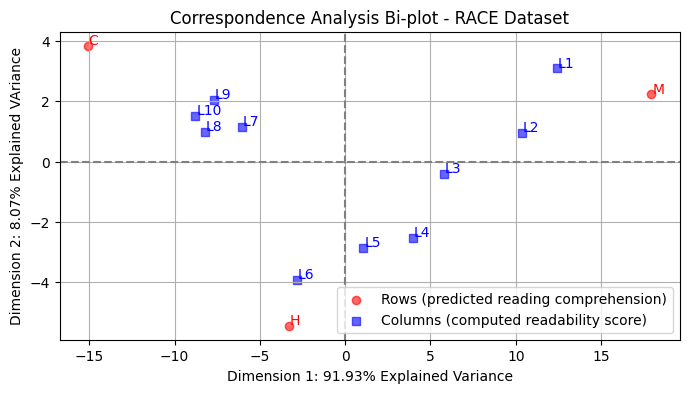

In [82]:
plot_correspondance_analysis(contingency_table=contingency_table_race, title='Correspondence Analysis Bi-plot - RACE Dataset',
                             row_label='Rows (predicted reading comprehension)', column_label='Columns (computed readability score)')

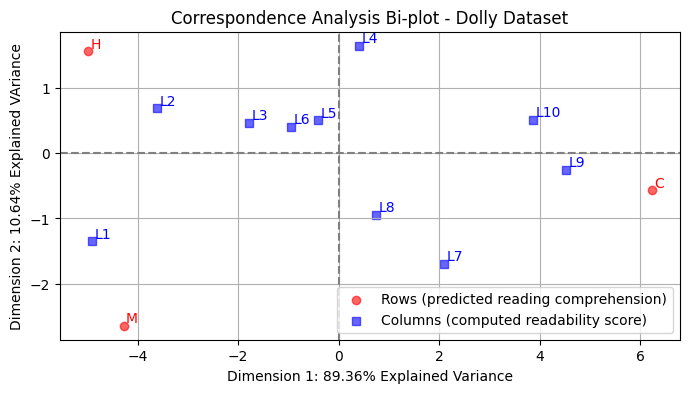

In [83]:
plot_correspondance_analysis(contingency_table=contingency_table_dolly, title='Correspondence Analysis Bi-plot - Dolly Dataset',
                             row_label='Rows (predicted reading comprehension)', column_label='Columns (computed readability score)')

In [33]:
df = dolly_cqa_df[dolly_cqa_df['predicted_difficulty'].isin(['C'])]
df = df[df['gf_score_categ']=='L8']

for text, categ in zip(df['text'], df['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L8 

### CONTEXT ###
Wine is an alcoholic drink typically made from fermented grapes. Yeast consumes the sugar in the grapes and converts it to ethanol and carbon dioxide, releasing heat in the process. Different varieties of grapes and strains of yeasts are major factors in different styles of wine. These differences result from the complex interactions between the biochemical development of the grape, the reactions involved in fermentation, the grape's growing environment (terroir), and the wine production process. Many countries enact legal appellations intended to define styles and qualities of wine. These typically restrict the geographical origin and permitted varieties of grapes, as well as other aspects of wine production. Wines can be made by fermentation of other fruit crops such as plum, cherry, pomegranate, blueberry, currant and elderberry.

### QUESTION ###
What is wine?

### ANSWER ###
Wine is an alcoholic drink typically made from fermented grapes.
 
gf_

In [34]:
def generate_percentage_table(*series_list, series_names=None, order=None):
    """
    Generates a table with the percentage of instances for each category level, for each series.
    
    Parameters:
    *series_list: One or more pandas Series.
    series_names: List of names for the series. Defaults to ['Series 1', 'Series 2', ...]
    order: List specifying the desired order of category levels in the table.
    
    Returns:
    DataFrame: A table with the percentage of instances for each category level, for each series.
    """
    
    if not series_names:
        series_names = [f"Series {i+1}" for i in range(len(series_list))]
    
    if len(series_list) != len(series_names):
        raise ValueError("The number of series and series names must match.")
    
    # Initialize a DataFrame to store the results
    df = pd.DataFrame()
    
    # For each series, calculate the percentage distribution of the categories
    for s, name in zip(series_list, series_names):
        df[name] = s.value_counts(normalize=True).mul(100).round().astype(int).astype(str) + '%'
    
    # Fill NaN with '0%' (this means that a particular category was not present in a series)
    df.fillna('0%', inplace=True)
    
    # If an order is provided, reorder the rows accordingly
    if order:
        df = df.reindex(order).fillna('0%')
    
    return df


In [35]:
generate_percentage_table(race_train_df['difficulty'], race_test_df['difficulty'], dolly_cqa_df['predicted_difficulty'],
                          series_names=['RACE train', 'RACE test', 'Dolly'], order=['M', 'H', 'C'])

,RACE train,RACE test,Dolly
M,32%,32%,6%
H,34%,34%,45%
C,34%,34%,49%


In [84]:
def plot_cluster_scores(df, categ, title, legend_title):
  
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    labels = df[categ].unique()
    labels = sorted(labels, key=lambda x: int(x[1:]))
    # labels = ['L' + str(i) for i in range(1,16)]

    sns.countplot(data=df, x='cluster', hue=categ, hue_order=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    
    # Place the legend outside the plot, to the right
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend.set_title(legend_title)
    
    plt.tight_layout()
    plt.show()

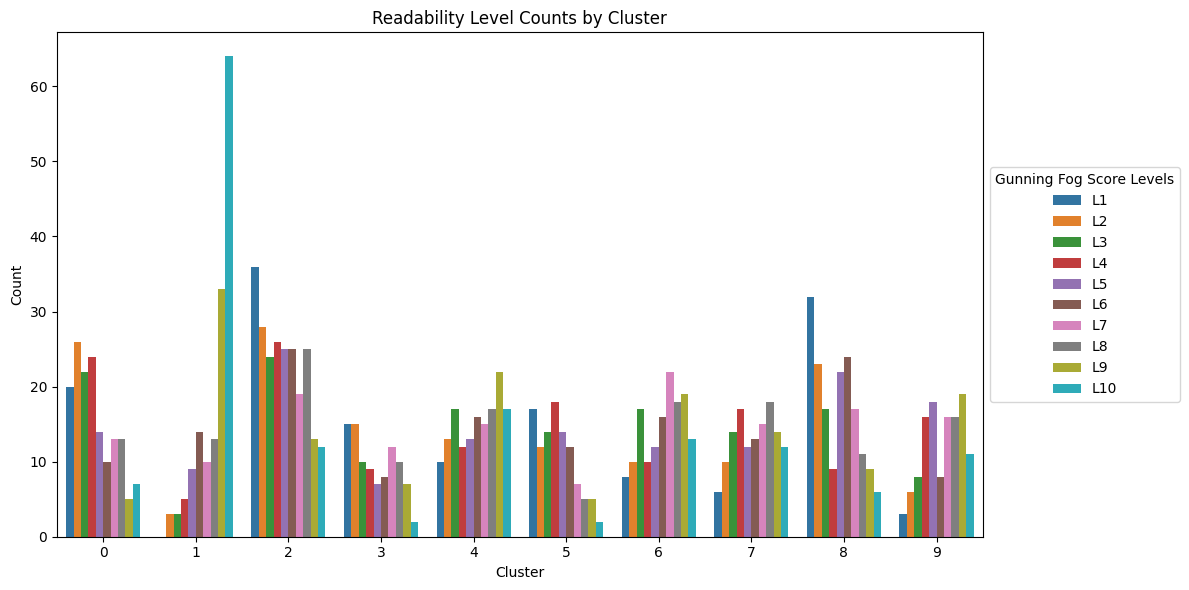

In [96]:
plot_cluster_scores(df=dolly_cqa_df, categ='gf_score_categ', title='Readability Level Counts by Cluster',
                    legend_title='Gunning Fog Score Levels')

In [97]:
df = dolly_cqa_df[dolly_cqa_df['cluster']==2]
df10 = df[df['gf_score_categ']=='L1']

for text, categ in zip(df10['text'], df10['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L1 

### CONTEXT ###
Kennedy was born on February 22, 1932, at St. Margaret's Hospital in the Dorchester section of Boston, Massachusetts. He was the youngest of the nine children of Joseph Patrick Kennedy and Rose Fitzgerald, members of prominent Irish American families in Boston. They constituted one of the wealthiest families in the nation after their marriage. His eight siblings were Joseph Jr., John, Rosemary, Kathleen, Eunice, Patricia, Robert, and Jean. His older brother John asked to be the newborn's godfather, a request his parents honored, though they did not agree to his request to name the baby George Washington Kennedy (Ted was born on President George Washington's 200th birthday). They named the boy after their father's assistant.

### QUESTION ###
Based on this paragraph, how many younger siblings did Kennedy have?

### ANSWER ###
Based on this paragraph, Kennedy had no younger siblings, as he was the youngest of nine children.
 
gf_score_categ: L1 

### 

In [95]:
df = dolly_cqa_df[dolly_cqa_df['cluster']==8]
df1 = df[df['gf_score_categ']=='L10']

for text, categ in zip(df1['text'], df1['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L10 

### CONTEXT ###
The Smuggler Cove Shell Midden (Smithsonian trinomial: 35TI46) is an archeological site located in Oswald West State Park near Neahkahnie Beach, Oregon, United States. First documented by archeologists in 1976, the midden has been found to contain remains of mussels, barnacles, and chiton to a depth of approximately 30 centimeters (12 in). Radiocarbon dating of a single sample of shell debris indicates that the Smuggler Cove campsite was occupied around 1660 CE, approximately the same date as the supposed wreck of a European ship at nearby Nehalem Spit, suggesting the site may preserve information from both before and after first contact between local people and Europeans. The site has been heavily damaged by construction of recreational facilities and coastal erosion, but a significant portion remains with potential to contribute to future research. Data generated from the site may help answer questions related to environmental change in the Orego

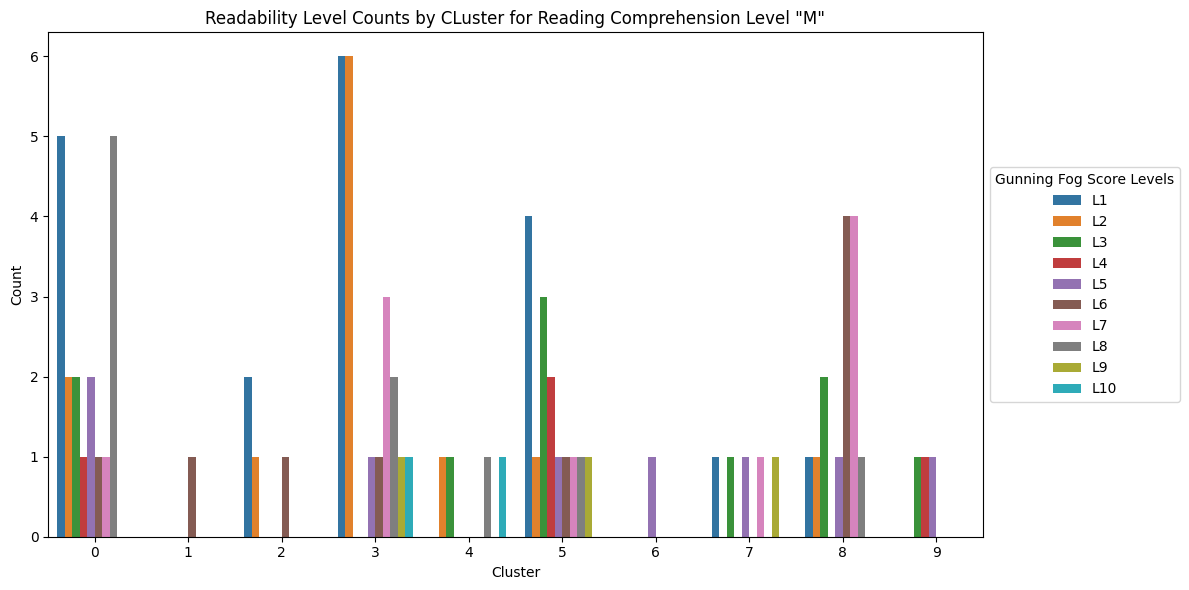

In [72]:
df = dolly_cqa_df[dolly_cqa_df['predicted_difficulty'].isin(['M'])]
plot_cluster_scores(df=df, categ='gf_score_categ', title='Readability Level Counts by CLuster for Reading Comprehension Level "M"',
                    legend_title='Gunning Fog Score Levels')

In [73]:
df0 = df[df['cluster']==0]
df0 = df0[df0['gf_score_categ']=='L8']

for text, categ in zip(df0['text'], df0['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L8 

### CONTEXT ###
Survivor is a reality-competition television franchise produced in many countries around the world. The show features a group of contestants deliberately marooned in an isolated location, where they must provide basic survival necessities for themselves. The contestants compete in challenges for rewards and immunity from elimination. The contestants are progressively eliminated from the game as they are voted out by their fellow contestants until only one remains to be awarded the grand prize and named the "Sole Survivor".

### QUESTION ###
Who is the 'sole Survivor' on the TV Show Survivor?

### ANSWER ###
The contestants are progressively eliminated from the game as they are voted out by their fellow contestants until only one remains to be awarded the grand prize and named the "Sole Survivor".
 
gf_score_categ: L8 

### CONTEXT ###
Modern K-pop "idol" culture began in the 1990s, as K-pop idol music grew into a subculture that amassed enormous fan

In [74]:
df8 = df[df['cluster']==8]
df8 = df8[df8['gf_score_categ'].isin(['L6', 'L7'])]

for text, categ in zip(df8['text'], df8['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L7 

### CONTEXT ###
Lakshmi Puja is celebrated as a part of Tihar, a second national festival of Nepal after Dashain. In Nepal, it is celebrated for five days, which include Kag (crow) Tihar; Kukur (dog) Tihar; Gai (cow) Tihar in the morning and Lakshmi Puja at night; Maha puja (self puja); Goru (Ox and Bull) Tihar and Gobardhan puja; and finally, Bhai Tika (Bhai dhooj)—respectively the first, second, third, fourth and fifth days.

### QUESTION ###
What is the last festival celebrated in Tihar and how long does the festival last?

### ANSWER ###
The festival lasts for 5 days and Bhai Tika is the last festival.
 
gf_score_categ: L6 

### CONTEXT ###
A love hotel is a type of short-stay hotel found around the world operated primarily for the purpose of allowing guests privacy for sexual activities. The name originates from "Hotel Love" in Osaka, which was built in 1968 and had a rotating sign. Although love hotels exist all over the world, the term "love hotel" is often 

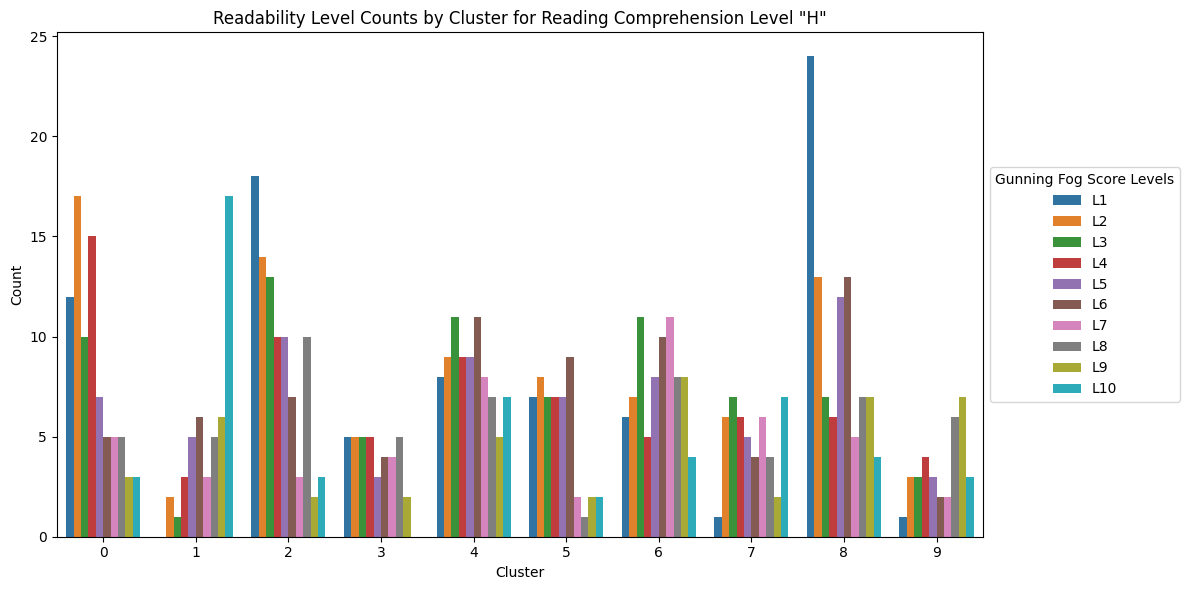

In [76]:
df = dolly_cqa_df[dolly_cqa_df['predicted_difficulty'].isin(['H'])]
plot_cluster_scores(df=df, categ='gf_score_categ', title='Readability Level Counts by Cluster for Reading Comprehension Level "H"',
                    legend_title='Gunning Fog Score Levels')

In [61]:
df8 = df[df['cluster']==8]
df8 = df8[df8['gf_score_categ']=='L1']

for text, categ in zip(df8['text'], df8['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L1 

### CONTEXT ###
The Malibamat'so River is a river in northern Lesotho. Its origin is near to the South African border, where it drains the eastern slopes of the Maloti Range. It flows southwards past the village of Lejone, and eventually joins the Senqu River 5 kilometres (3.1 mi) northeast of Mohlanapeng.

The Malibamat'so forms the northern arm of the Katse Dam reservoir, a part of the Lesotho Highlands Water Project. Katse is Africa's highest elevation dam at 1,993 metres (6,539 ft) above sea level. Here the river is joined by the Bokong/Bokung River. Downstream the Malibamat'so's left bank tributaries are the Matsoku and Semenanyane Rivers, before it forms a right bank tributary of the Senqu/Orange River.

### QUESTION ###
Malibamat'so River

### ANSWER ###
Malibamat'so River is a river in northern Lesotho. Its origin is near to the South African border, where it drains the eastern slopes of the Maloti Range. It flows southwards past the village of Lejone, and 

In [62]:
df1 = df[df['cluster']==1]
df1 = df1[df1['gf_score_categ']=='L10']

for text, categ in zip(df1['text'], df1['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L10 

### CONTEXT ###
Marketing Automation is a subset of customer relationship management (CRM) or customer experience management (CXM) that focuses on the definition, segmentation, scheduling and tracking of marketing campaigns. The use of marketing automation makes processes that would otherwise have been performed manually much more efficient and makes new processes possible. Marketing Automation can be defined as a process where technology is used to automate several repetitive tasks that are undertaken on a regular basis in a marketing campaign.

Marketing Automation platforms allow marketers to automate and simplify client communication by managing complex omnichannel marketing strategies from a single tool. Marketing Automation assists greatly in areas like Lead Generation, Segmentation, Lead nurturing and lead scoring, Relationship marketing, Cross-sell and upsell, Retention, Marketing ROI measurement. Effective marketing automation tools leverage data from a s

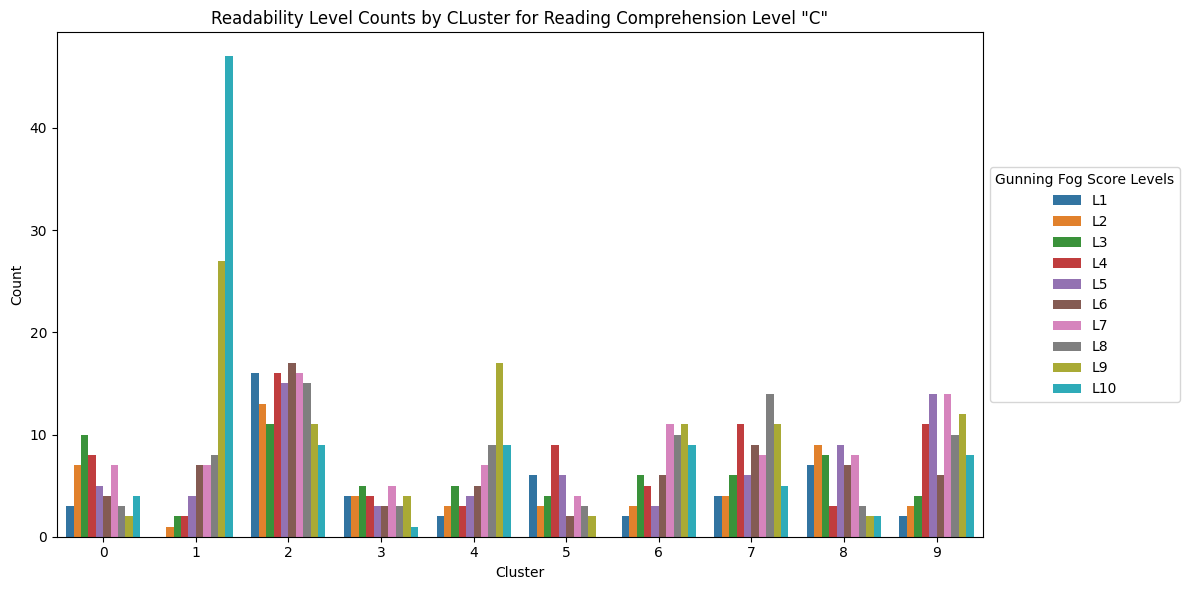

In [63]:
df = dolly_cqa_df[dolly_cqa_df['predicted_difficulty'].isin(['C'])]
plot_cluster_scores(df=df, categ='gf_score_categ', title='Readability Level Counts by CLuster for Reading Comprehension Level "C"',
                    legend_title='Gunning Fog Score Levels')

In [64]:
df1 = df[df['cluster']==1]
df1 = df1[df1['gf_score_categ']=='L10']

for text, categ in zip(df1['text'], df1['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L10 

### CONTEXT ###
Exogamy often results in two individuals that are not closely genetically related marrying each other; that is, outbreeding as opposed to inbreeding. In moderation, this benefits the offspring as it reduces the risk of the offspring inheriting two copies of a defective gene. Increasing the genetic diversity of the offspring improves the chances of offspring reproducing, up until the fourth-cousin level of relatedness; however, reproduction between individuals on the fourth-cousin level of relatedness decreases evolutionarily fitness.

### QUESTION ###
Does "outbreeding" or "inbreeding" benefit the offspring more?

### ANSWER ###
"Outbreeding" is more beneficial to the offspring as it reduces the risk of inheriting defective genes, increasing the offspring's ability to reproduce.
 
gf_score_categ: L10 

### CONTEXT ###
The law of triviality is C. Northcote Parkinson's 1957 argument that people within an organization commonly or typically give dispro

In [65]:
df2 = df[df['cluster']==2]
df2 = df2[df2['gf_score_categ']=='L1']

for text, categ in zip(df2['text'], df2['gf_score_categ']):
    print('gf_score_categ:', categ, '\n')
    print(text, '\n=============================================================')

gf_score_categ: L1 

### CONTEXT ###
The E.S. Hoyt House is a historic house in Red Wing, Minnesota, United States, designed by the firm of Purcell & Elmslie and built in 1913. The house is listed on the National Register of Historic Places. It is also a contributing property to the Red Wing Residential Historic District.

Description and history
The house is one of their more elaborate designs because its owner had a budget that allowed for lavish decoration. The result is comparable to the William Gray Purcell House and the Edward L. Powers House, both in Minneapolis. The horizontal lines of the Prairie School are more pronounced in this house; they are expressed in the bands of art glass windows on both levels and the cantilevered second story. Its owner, E.S. Hoyt, was the president of the Red Wing Stoneware Company.

The exterior is clad with brick on the first floor and red stucco on the second floor. The house has ten rooms and about 3,600 square feet (330 m2) of floor space. It

In [66]:
def plot_cluster_scores(df, categ, title, legend_title):
  
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    labels = ['M', 'H', 'C']

    sns.countplot(data=df, x='cluster', hue=categ, hue_order=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    
    # Place the legend outside the plot, to the right
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend.set_title(legend_title)
    
    plt.tight_layout()
    plt.show()

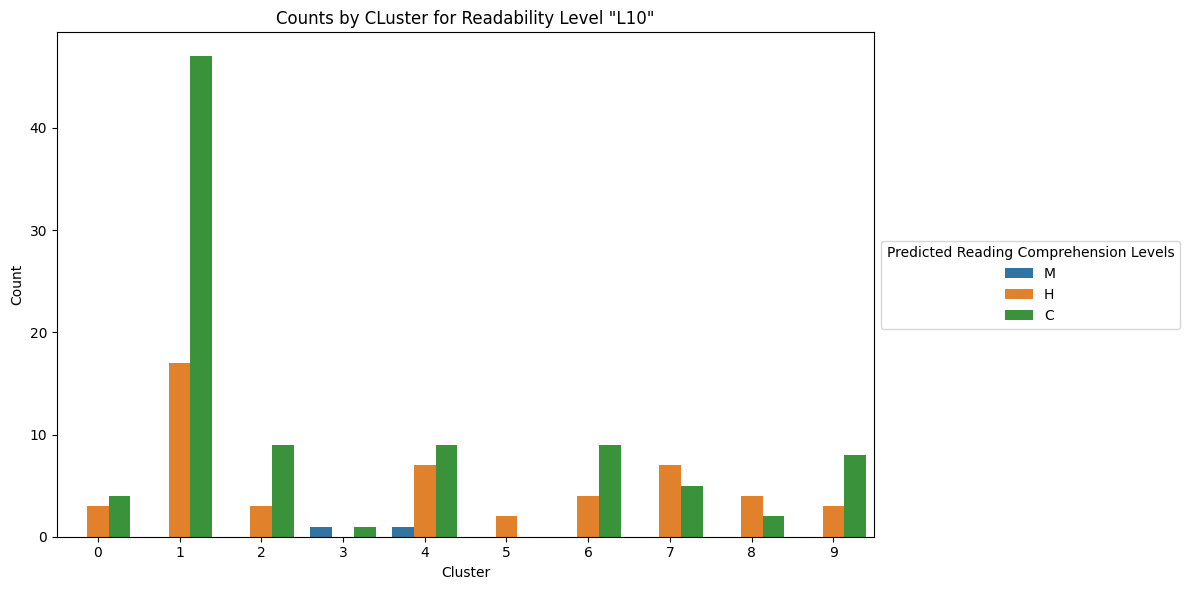

In [67]:
df = dolly_cqa_df[dolly_cqa_df['gf_score_categ'].isin(['L10'])]
plot_cluster_scores(df=df, categ='predicted_difficulty', title='Counts by CLuster for Readability Level "L10"',
                    legend_title='Predicted Reading Comprehension Levels')

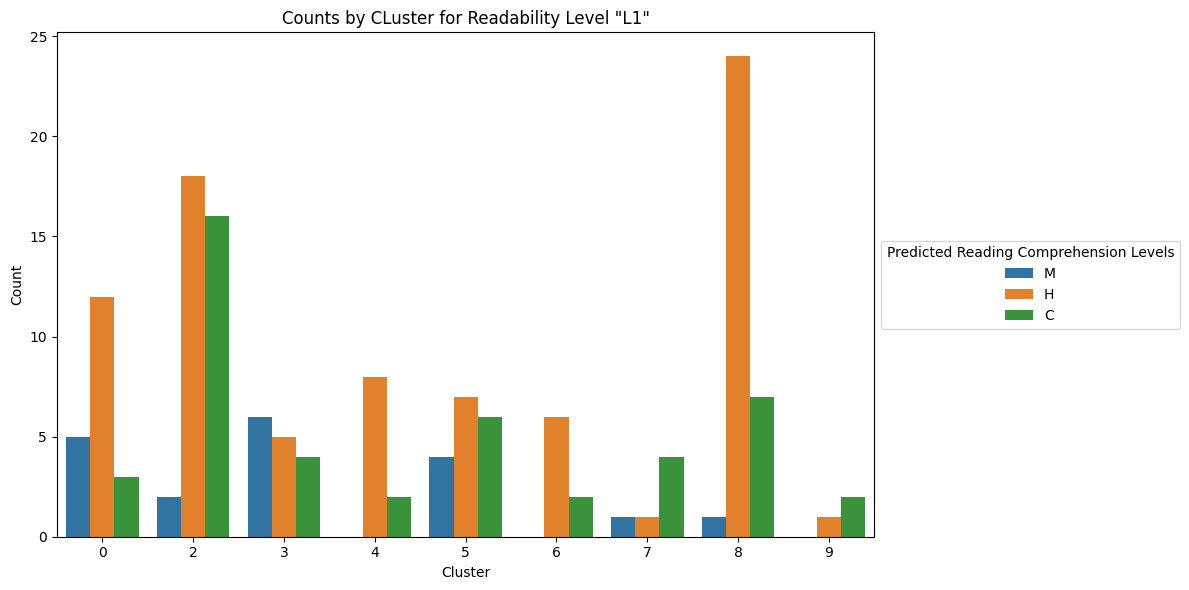

In [68]:
df = dolly_cqa_df[dolly_cqa_df['gf_score_categ'].isin(['L1'])]
plot_cluster_scores(df=df, categ='predicted_difficulty', title='Counts by CLuster for Readability Level "L1"',
                    legend_title='Predicted Reading Comprehension Levels')

In [69]:
df2 = df[df['cluster']==2]
df2 = df2[df2['predicted_difficulty']=='C']

for text, level in zip(df2['text'], df2['predicted_difficulty']):
    print('predicted difficulty:', level, '\n')
    print(text, '\n=============================================================')

predicted difficulty: C 

### CONTEXT ###
The E.S. Hoyt House is a historic house in Red Wing, Minnesota, United States, designed by the firm of Purcell & Elmslie and built in 1913. The house is listed on the National Register of Historic Places. It is also a contributing property to the Red Wing Residential Historic District.

Description and history
The house is one of their more elaborate designs because its owner had a budget that allowed for lavish decoration. The result is comparable to the William Gray Purcell House and the Edward L. Powers House, both in Minneapolis. The horizontal lines of the Prairie School are more pronounced in this house; they are expressed in the bands of art glass windows on both levels and the cantilevered second story. Its owner, E.S. Hoyt, was the president of the Red Wing Stoneware Company.

The exterior is clad with brick on the first floor and red stucco on the second floor. The house has ten rooms and about 3,600 square feet (330 m2) of floor spac

In [70]:
df8 = df[df['cluster']==8]
df8 = df8[df8['predicted_difficulty']=='H']

for text, level in zip(df8['text'], df8['predicted_difficulty']):
    print('predicted difficulty:', level, '\n')
    print(text, '\n=============================================================')

predicted difficulty: H 

### CONTEXT ###
The Malibamat'so River is a river in northern Lesotho. Its origin is near to the South African border, where it drains the eastern slopes of the Maloti Range. It flows southwards past the village of Lejone, and eventually joins the Senqu River 5 kilometres (3.1 mi) northeast of Mohlanapeng.

The Malibamat'so forms the northern arm of the Katse Dam reservoir, a part of the Lesotho Highlands Water Project. Katse is Africa's highest elevation dam at 1,993 metres (6,539 ft) above sea level. Here the river is joined by the Bokong/Bokung River. Downstream the Malibamat'so's left bank tributaries are the Matsoku and Semenanyane Rivers, before it forms a right bank tributary of the Senqu/Orange River.

### QUESTION ###
Malibamat'so River

### ANSWER ###
Malibamat'so River is a river in northern Lesotho. Its origin is near to the South African border, where it drains the eastern slopes of the Maloti Range. It flows southwards past the village of Lejone,

In [52]:
def plot_boxplots(df, categ):
    # List of continuous columns
    columns = ['difficulty_proba_M', 'difficulty_proba_C', 'difficulty_proba_H']
    
    # Setting up the figure and axes
    fig, axs = plt.subplots(nrows=3, figsize=(10, 15))
    
    # Looping through each column and plotting
    for i, column in enumerate(columns):
        sns.boxplot(x=categ, y=column, data=df, ax=axs[i], order=['L' + str(i) for i in range(1,10)])
        axs[i].set_title(f"Boxplot of {column} by {categ}")
    
    # Displaying the plots
    plt.tight_layout()
    plt.show()


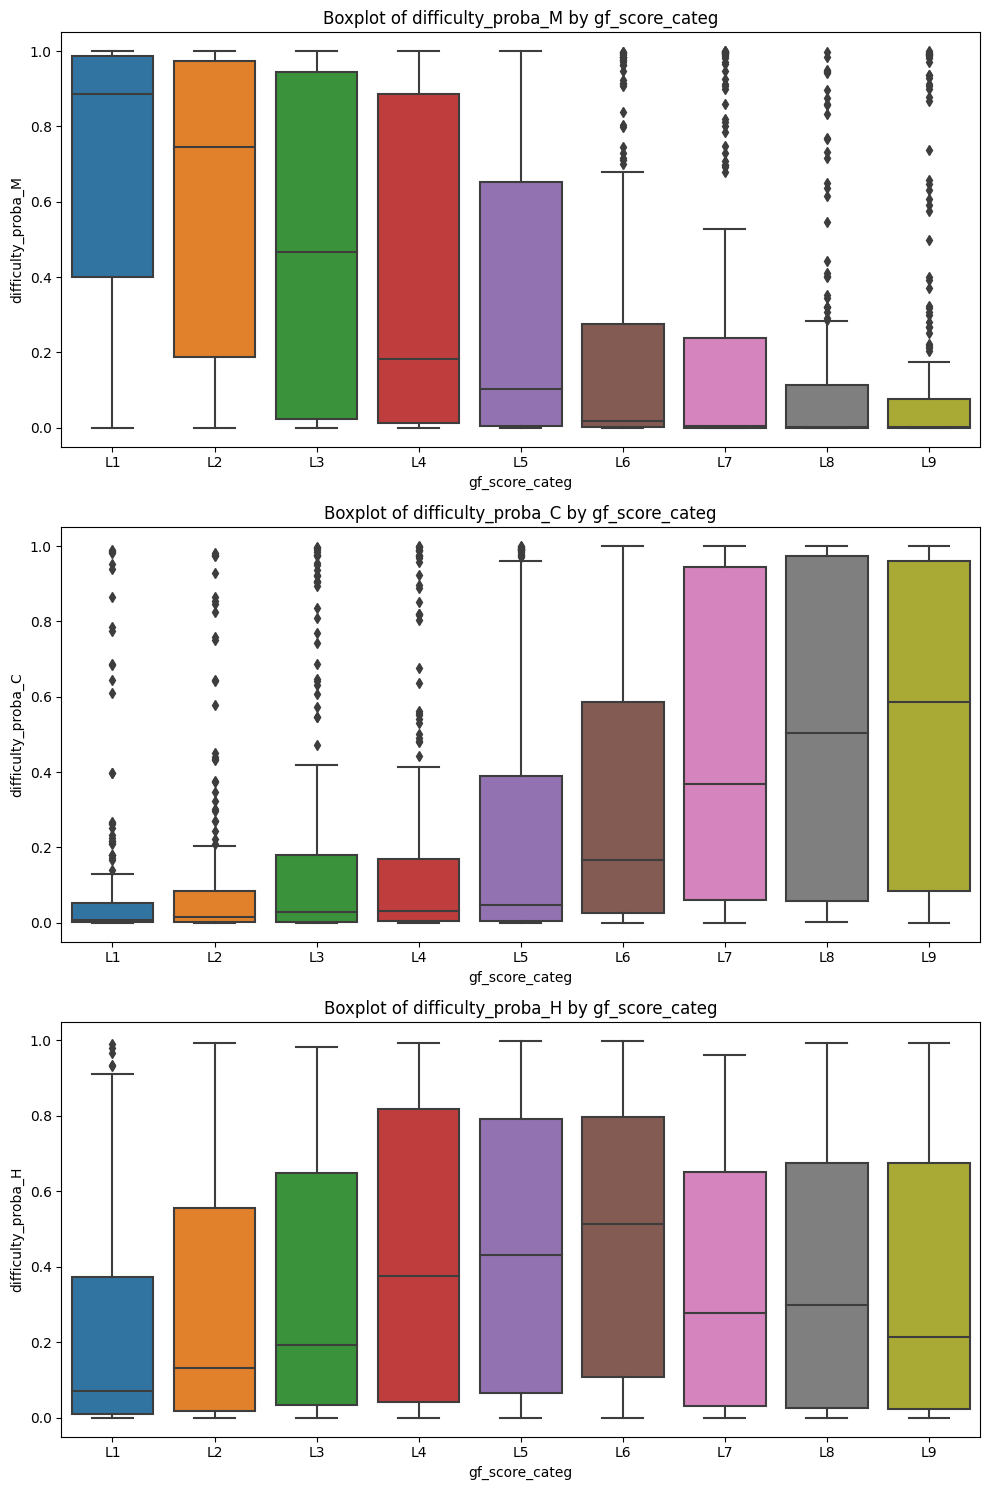

In [53]:
plot_boxplots(race_test_df, 'gf_score_categ')

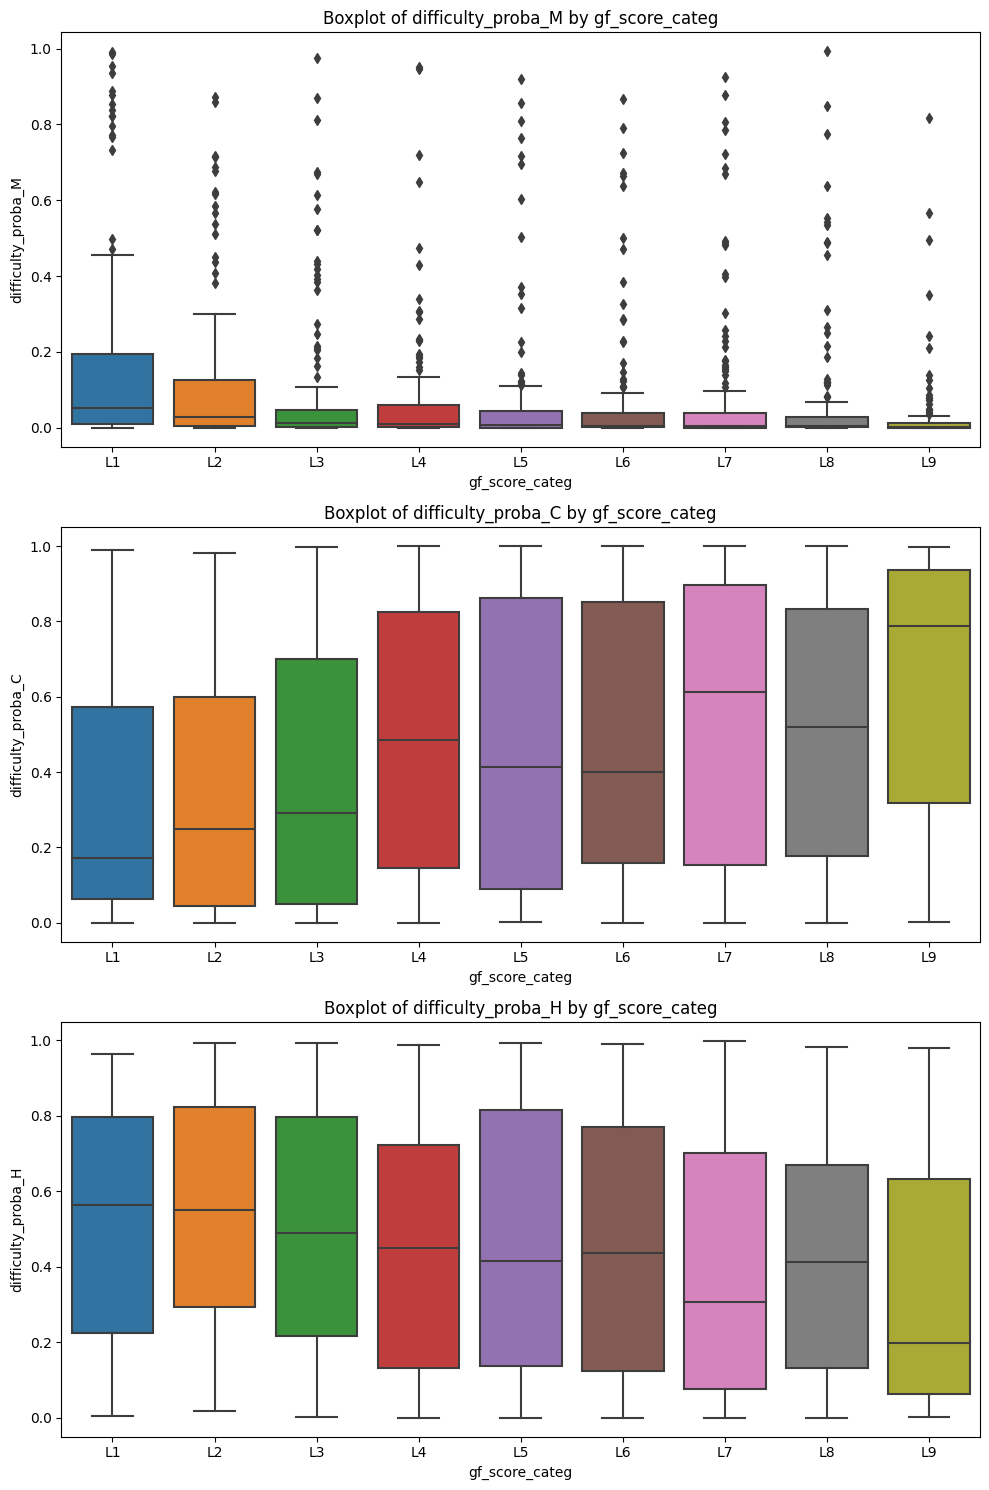

In [54]:
plot_boxplots(dolly_cqa_df, 'gf_score_categ')